In [ ]:
# Mount to drive

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=390d9ac3cd123330305ae6e3ca75bfd194aec2f7cf9016cc8fea91e5735d18a4
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
!pip install  geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 103.4 MB/s eta 0:00:00


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import max
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
spark = SparkSession.builder.appName("MalnutritionAnalysis").getOrCreate()

In [ ]:
data = spark.read.csv("/content/drive/MyDrive/Analisis_Kecacatan/big-data.csv", header=True, inferSchema=True)
data.head()

Row(id=1, kode_provinsi=32, nama_provinsi='JAWA BARAT', kode_kabupaten_kota=3201, nama_kabupaten_kota='KABUPATEN BOGOR', kategori_disabilitas='CACAT FISIK', jumlah_penduduk=634, satuan='JIWA', tahun=2013)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql.types import IntegerType

# Inisialisasi SparkSession
spark = SparkSession.builder.getOrCreate()

# Membaca data dari file CSV
df = spark.read.csv("/content/drive/MyDrive/Analisis_Kecacatan/big-data.csv", header=True, inferSchema=True)
df = df.dropDuplicates().na.drop()

# Mengubah tipe data kolom tahun menjadi Integer
df = df.withColumn("tahun", df["tahun"].cast(IntegerType()))

# Menghitung rata-rata jumlah_penduduk berdasarkan kode_provinsi dan tahun
avg_jumlah_penduduk_df = df.groupBy("kode_provinsi", "tahun").agg(avg("jumlah_penduduk").alias("avg_jumlah_penduduk"))

# Bergabung dengan DataFrame awal untuk mendapatkan kolom avg_jumlah_penduduk
df_with_avg_jumlah_penduduk = df.join(avg_jumlah_penduduk_df, ["kode_provinsi", "tahun"])

# Menampilkan hasil
df_with_avg_jumlah_penduduk.show()


+-------------+-----+---+-------------+-------------------+--------------------+--------------------+---------------+------+-------------------+
|kode_provinsi|tahun| id|nama_provinsi|kode_kabupaten_kota| nama_kabupaten_kota|kategori_disabilitas|jumlah_penduduk|satuan|avg_jumlah_penduduk|
+-------------+-----+---+-------------+-------------------+--------------------+--------------------+---------------+------+-------------------+
|           32| 2015|423|   JAWA BARAT|               3217|KABUPATEN BANDUNG...|  CACAT RUNGU/WICARA|             47|  JIWA| 271.14814814814815|
|           32| 2015|340|   JAWA BARAT|               3203|   KABUPATEN CIANJUR|   CACAT MENTAL/JIWA|            135|  JIWA| 271.14814814814815|
|           32| 2015|474|   JAWA BARAT|               3277|         KOTA CIMAHI|       CACAT LAINNYA|            105|  JIWA| 271.14814814814815|
|           32| 2015|383|   JAWA BARAT|               3210|KABUPATEN MAJALENGKA|CACAT FISIK DAN M...|             51|  JIWA| 271.1

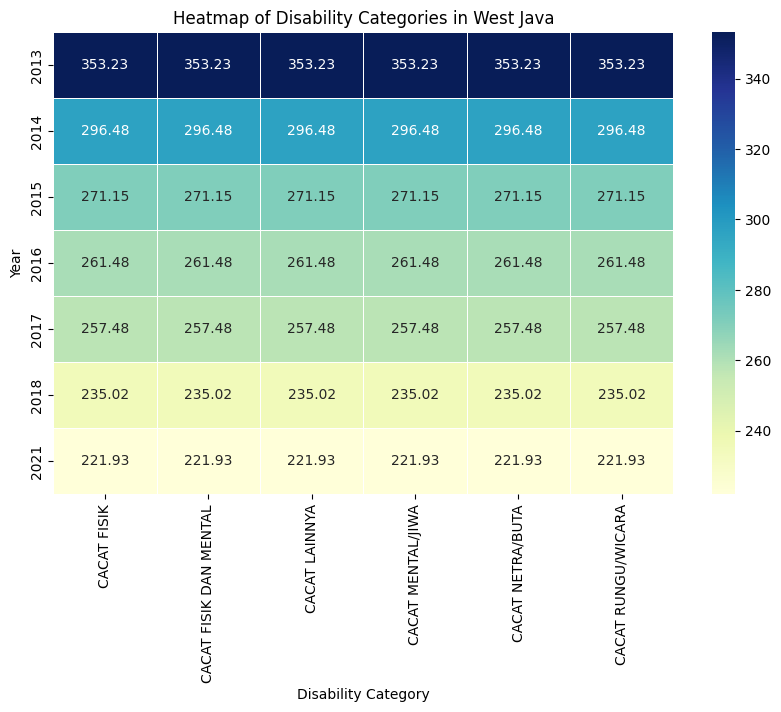

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Mengambil data Jawa Barat dari DataFrame
jawa_barat_df = df_with_avg_jumlah_penduduk.filter(df_with_avg_jumlah_penduduk["kode_provinsi"] == "32")

# Mengurutkan data berdasarkan tahun secara ascending
jawa_barat_df = jawa_barat_df.orderBy("tahun")

# Mengubah DataFrame menjadi Pandas DataFrame
jawa_barat_pd = jawa_barat_df.toPandas()

# Pivot tabel dengan menggunakan fungsi agregasi mean untuk menggabungkan nilai-nilai yang memiliki tahun yang sama
jawa_barat_pivot = jawa_barat_pd.pivot_table(index="tahun", columns="kategori_disabilitas", values="avg_jumlah_penduduk", aggfunc="mean")

# Membuat heatmap menggunakan seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(jawa_barat_pivot, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5, cbar=True)
plt.xlabel("Disability Category")
plt.ylabel("Year")
plt.title("Heatmap of Disability Categories in West Java")
plt.show()


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum

# Inisialisasi SparkSession
spark = SparkSession.builder.getOrCreate()

# Membaca data dari file CSV
df = spark.read.csv("/content/drive/MyDrive/Analisis_Kecacatan/big-data.csv", header=True, inferSchema=True)
df = df.dropDuplicates().na.drop()

# Menghitung rata-rata jumlah_penduduk berdasarkan kode_provinsi dan tahun
avg_jumlah_penduduk_df = df.groupBy("kode_provinsi", "tahun").agg(avg("jumlah_penduduk").alias("avg_jumlah_penduduk"))

# Bergabung dengan DataFrame awal untuk mendapatkan kolom avg_jumlah_penduduk
df_with_avg_jumlah_penduduk = df.join(avg_jumlah_penduduk_df, ["kode_provinsi", "tahun"])

# Menghitung jumlah penduduk berdasarkan kategori kecacatan
jumlah_penduduk_kecacatan = df_with_avg_jumlah_penduduk.groupBy("kategori_disabilitas").agg(sum("avg_jumlah_penduduk").alias("total_jumlah_penduduk"))

# Mengurutkan hasil secara descending (terbesar hingga terkecil)
jumlah_penduduk_kecacatan = jumlah_penduduk_kecacatan.orderBy("total_jumlah_penduduk", ascending=False)

# Menampilkan hasil
jumlah_penduduk_kecacatan.show()


+--------------------+---------------------+
|kategori_disabilitas|total_jumlah_penduduk|
+--------------------+---------------------+
|    CACAT NETRA/BUTA|   51212.666666666824|
|CACAT FISIK DAN M...|   51212.666666666824|
|   CACAT MENTAL/JIWA|   51212.666666666824|
|       CACAT LAINNYA|   51212.666666666824|
|  CACAT RUNGU/WICARA|   51212.666666666824|
|         CACAT FISIK|   51212.666666666824|
+--------------------+---------------------+



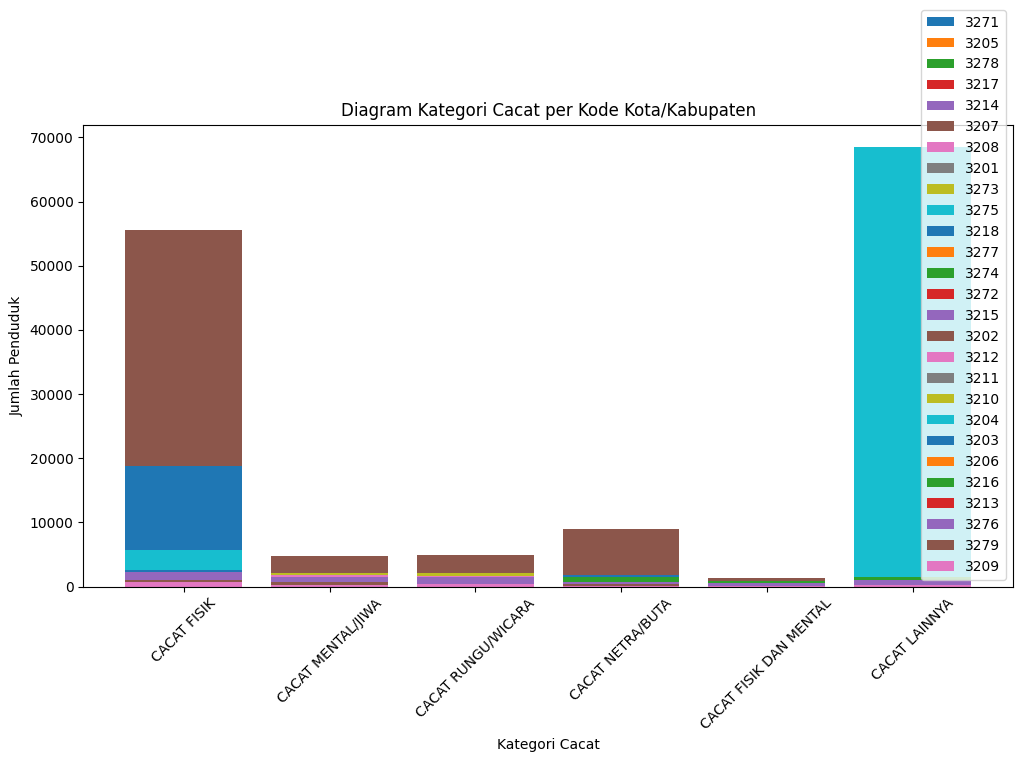

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum

# Inisialisasi SparkSession
spark = SparkSession.builder.getOrCreate()

# Membaca data dari file CSV
df = spark.read.csv("/content/drive/MyDrive/Analisis_Kecacatan/big-data.csv", header=True, inferSchema=True)
df = df.dropDuplicates().na.drop()

# Menghitung jumlah penduduk berdasarkan kode_kabupaten_kota dan kategori_disabilitas
jumlah_penduduk_kota_kabupaten = df.groupBy("kode_kabupaten_kota", "kategori_disabilitas").agg(sum("jumlah_penduduk").alias("total_jumlah_penduduk"))

# Mengumpulkan data dalam format Pandas DataFrame
data_pd = jumlah_penduduk_kota_kabupaten.toPandas()

# Menampilkan diagram kategori cacat untuk setiap kode kota/kabupaten
fig, ax = plt.subplots(figsize=(12, 6))

# Loop melalui setiap kode kota/kabupaten
for kode in data_pd["kode_kabupaten_kota"].unique():
    data_kota_kabupaten = data_pd[data_pd["kode_kabupaten_kota"] == kode]
    ax.bar(data_kota_kabupaten["kategori_disabilitas"], data_kota_kabupaten["total_jumlah_penduduk"], label=kode)

ax.set_xlabel("Kategori Cacat")
ax.set_ylabel("Jumlah Penduduk")
ax.set_title("Diagram Kategori Cacat per Kode Kota/Kabupaten")
ax.legend()
plt.xticks(rotation=45)
plt.show()

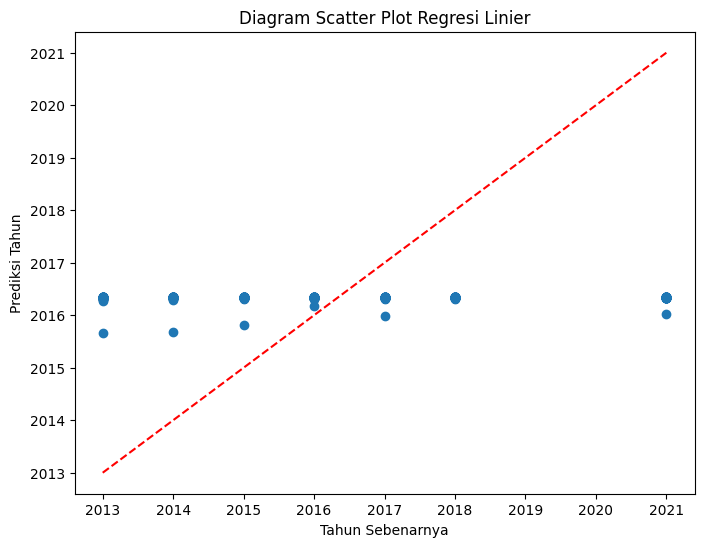

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Inisialisasi SparkSession
spark = SparkSession.builder.getOrCreate()

# Membaca data dari file CSV
df = spark.read.csv("/content/drive/MyDrive/Analisis_Kecacatan/big-data.csv", header=True, inferSchema=True)
df = df.dropDuplicates().na.drop()

# Menghapus baris dengan nilai kosong atau tidak terdefinisi pada kolom 'tahun'
df = df.filter(col("tahun").isNotNull())

# Memilih fitur yang akan digunakan dalam model
feature_columns = ['jumlah_penduduk']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(df)

# Membagi data menjadi training set dan testing set
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Memeriksa apakah training dataset tidak kosong
if trainingData.count() == 0:
    raise ValueError("Training dataset is empty. Adjust the split ratio or check the data.")

# Membuat objek regresi linier
lr = LinearRegression(featuresCol="features", labelCol="tahun")

# Melatih model menggunakan training set
model = lr.fit(trainingData)

# Melakukan prediksi terhadap testing set
predictions = model.transform(testData)

# Mengumpulkan hasil prediksi dalam format Pandas DataFrame
predictions_pd = predictions.select("prediction", "tahun").toPandas()

# Membuat diagram scatter plot untuk membandingkan prediksi dengan nilai sebenarnya
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(predictions_pd["tahun"], predictions_pd["prediction"])
ax.plot([predictions_pd["tahun"].min(), predictions_pd["tahun"].max()],
        [predictions_pd["tahun"].min(), predictions_pd["tahun"].max()], 'r--')
ax.set_xlabel("Tahun Sebenarnya")
ax.set_ylabel("Prediksi Tahun")
ax.set_title("Diagram Scatter Plot Regresi Linier")
plt.show()


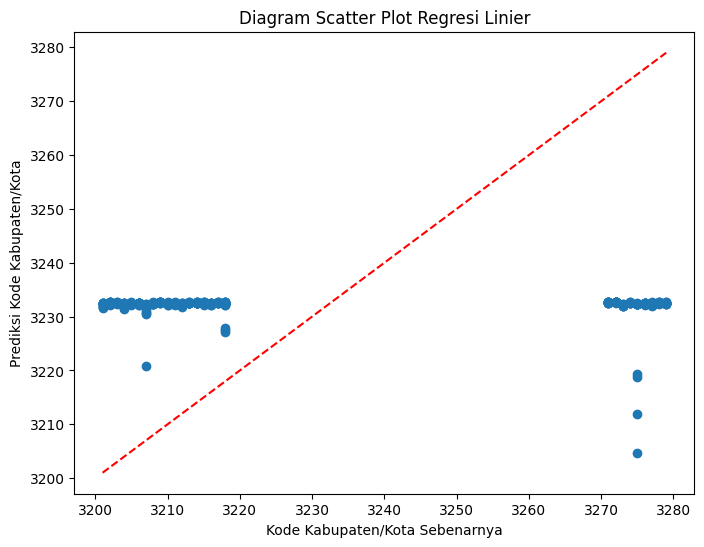

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Inisialisasi SparkSession
spark = SparkSession.builder.getOrCreate()

# Membaca data dari file CSV
df = spark.read.csv("/content/drive/MyDrive/Analisis_Kecacatan/big-data.csv", header=True, inferSchema=True)
df = df.dropDuplicates().na.drop()

# Menghapus baris dengan nilai kosong atau tidak terdefinisi pada kolom 'kode_kabupaten_kota'
df = df.filter(col("kode_kabupaten_kota").isNotNull())

# Memilih fitur yang akan digunakan dalam model
feature_columns = ['jumlah_penduduk']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(df)

# Membagi data menjadi training set dan testing set
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Memeriksa apakah training dataset tidak kosong
if trainingData.count() == 0:
    raise ValueError("Training dataset is empty. Adjust the split ratio or check the data.")

# Membuat objek regresi linier
lr = LinearRegression(featuresCol="features", labelCol="kode_kabupaten_kota")

# Melatih model menggunakan training set
model = lr.fit(trainingData)

# Melakukan prediksi terhadap testing set
predictions = model.transform(testData)

# Mengumpulkan hasil prediksi dalam format Pandas DataFrame
predictions_pd = predictions.select("prediction", "kode_kabupaten_kota").toPandas()

# Membuat diagram scatter plot untuk membandingkan prediksi dengan nilai sebenarnya
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(predictions_pd["kode_kabupaten_kota"], predictions_pd["prediction"])
ax.plot([predictions_pd["kode_kabupaten_kota"].min(), predictions_pd["kode_kabupaten_kota"].max()],
        [predictions_pd["kode_kabupaten_kota"].min(), predictions_pd["kode_kabupaten_kota"].max()], 'r--')
ax.set_xlabel("Kode Kabupaten/Kota Sebenarnya")
ax.set_ylabel("Prediksi Kode Kabupaten/Kota")
ax.set_title("Diagram Scatter Plot Regresi Linier")
plt.show()